# COMPARISON MODULE

This notebook shows how to use the spiketoolkit.comparison module to:
  1. compare pair of spike sorters
  2. compare multiple spike sorters
  3. extract units in agreement with multiple sorters (consensus-based)
  4. run systematic performance comparisons on ground truth recordings

In [1]:
import spiketoolkit as st
import spikeextractors as se
import numpy as np
import pandas as pd
import seaborn as sn
import shutil
import time
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib notebook

10:48:28 [I] klustakwik KlustaKwik2 version 0.2.6
/afs/inf.ed.ac.uk/user/s17/s1727843/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/networkx-2.2-py3.7.egg/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


### Create a toy example dataset

In [2]:
recording, sorting_true = se.example_datasets.toy_example(duration=60, seed=0)

## 1) Compare two spike sorters

First, we will run two spike sorters and compare their ouput.

In [3]:
sorting_KL = st.sorters.run_klusta(recording)
sorting_MS4 = st.sorters.run_mountainsort4(recording)

'group' property is not available and it will not be saved.
{'detect_sign': -1, 'adjacency_radius': -1, 'freq_min': 300, 'freq_max': 6000, 'filter': False, 'curation': True, 'whiten': True, 'clip_size': 50, 'detect_threshold': 3, 'detect_interval': 10, 'noise_overlap_threshold': 0.15}
Using 2 workers.
Using tmpdir: /tmp/tmpqf9k0bwe
Num. workers = 2
Preparing /tmp/tmpqf9k0bwe/timeseries.hdf5...
Preparing neighborhood sorters (M=4, N=1800000)...
Neighboorhood of channel 0 has 4 channels.
Neighboorhood of channel 1 has 4 channels.
Detecting events on channel 2 (phase1)...
Detecting events on channel 1 (phase1)...
Elapsed time for detect on neighborhood: 0:00:00.686374
Num events detected on channel 1 (phase1): 1622
Computing PCA features for channel 1 (phase1)...
Elapsed time for detect on neighborhood: 0:00:00.886737
Num events detected on channel 2 (phase1): 1530
Computing PCA features for channel 2 (phase1)...
Clustering for channel 1 (phase1)...
Clustering for channel 2 (phase1)...
Fo

The `compare_two_sorters` function allows us to compare the spike sorting output. It returns a `SortingComparison` object, with methods to inspect the comparison output easily.

In [4]:
cmp_KL_MS4 = st.comparison.compare_two_sorters(sorting1=sorting_KL, sorting2=sorting_MS4, 
                                               sorting1_name='klusta', sorting2_name='ms4')

In order to check which units were matched, the `get_mapped_sorting` methods can be used. If units are not matched they are listed as -1.

In [5]:
# units matched to klusta units
mapped_sorting_klusta = cmp_KL_MS4.get_mapped_sorting1()
print('Klusta units:', sorting_KL.get_unit_ids())
print('Klusta mapped units:', mapped_sorting_klusta.get_mapped_unit_ids())

# units matched to ms4 units
mapped_sorting_ms4 = cmp_KL_MS4.get_mapped_sorting2()
print('Mountainsort units:',sorting_MS4.get_unit_ids())
print('Mountainsort mapped units:',mapped_sorting_ms4.get_mapped_unit_ids())

Klusta units: [0, 2, 3, 4, 5, 6, 7, 8]
Klusta mapped units: [-1, -1, -1, -1, 4, -1, 8, 15]
Mountainsort units: [ 3  4  5  7  8  9 11 13 15]
Mountainsort mapped units: [-1, 5, -1, -1, 7, -1, -1, -1, 8]


The `get_unit_spike_train` returns the mapped spike train. We can use it to check the spike times.

Klusta spike train: [  2377   4242  19418  25404  27643  49031  82028  89543  95559 136556]
Mountainsort spike trains [  2377   4243  49031  82028  89543  95559 136556 136780 167029 168402]


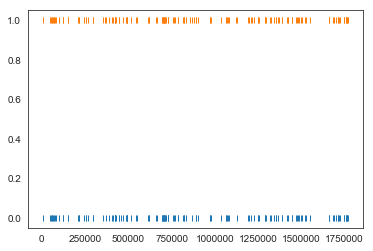

In [6]:
# check that matched spike trains correspond
plt.plot(sorting_KL.get_unit_spike_train(7), 
         np.zeros(len(sorting_KL.get_unit_spike_train(7))), '|')
plt.plot(mapped_sorting_klusta.get_unit_spike_train(7),
         np.ones(len(mapped_sorting_klusta.get_unit_spike_train(7))), '|')

print('Klusta spike train:', sorting_KL.get_unit_spike_train(8)[:10])
print('Mountainsort spike trains', mapped_sorting_klusta.get_unit_spike_train(8)[:10])

To get an overview of the performance, we can use the `get_performance` method. By default, it returns a pandas dataframe with the comparison measures. It can also pull the results by average and by sum.

In [7]:
cmp_KL_MS4.get_performance()

,tp_rate,fn_rate,cl_rate,fp_rate_st1,fp_rate_st2,accuracy,sensitivity,precision,miss_rate,false_discovery_rate
0,0,100,0,0,NaN,0,0,NaN,100,NaN
2,0,100,0,0,NaN,0,0,NaN,100,NaN
3,0,100,0,0,NaN,0,0,NaN,100,NaN
4,0,100,0,0,NaN,0,0,NaN,100,NaN
5,100,0,100,56.9892,36.3014,63.6986,100,63.6986,0,36.3014
6,0,100,0,0,NaN,0,0,NaN,100,NaN
7,99.2481,0.75188,99.2481,6.01504,5.71429,93.617,99.2481,94.2857,0.75188,5.71429
8,53.0909,46.9091,53.0909,0.727273,1.35135,52.7076,53.0909,98.6486,46.9091,1.35135


In [8]:
cmp_KL_MS4.get_performance(method='pooled_with_average')

tp_rate                 31.542379
fn_rate                 68.457621
cl_rate                 31.542379
fp_rate_st1              7.966445
fp_rate_st2             14.455669
accuracy                26.252904
sensitivity             31.542379
precision               85.544331
miss_rate               68.457621
false_discovery_rate    14.455669
dtype: float64

In [9]:
cmp_KL_MS4.get_performance(method='pooled_with_sum')

tp_rate                 31.574468
fn_rate                 68.425532
cl_rate                  0.000000
fp_rate_st1             77.787234
fp_rate_st2             71.128405
accuracy                17.759694
sensitivity             31.574468
precision               28.871595
miss_rate               68.425532
false_discovery_rate    71.128405
dtype: float64

## 2) Compare multiple spike sorters

With 3 or more spike sorters, the comparison is implemented with a graph-based method. The multiple sorter comparison also allows to clean the output by applying a consensus-based method which only selects spike trains and spikes in agreement with multiple sorters.

In [10]:
sorting_TDC = st.sorters.run_tridesclous(recording)

'group' property is not available and it will not be saved.


/afs/inf.ed.ac.uk/user/s17/s1727843/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/tridesclous/dataio.py:215: ResourceWarning: unclosed file <_io.TextIOWrapper name='/afs/inf.ed.ac.uk/user/s17/s1727843/spiketoolkit/examples/test_tridesclous/default.prb' mode='r' encoding='UTF-8'>
  exec(open(probe_filename).read(), None, d)
/afs/inf.ed.ac.uk/user/s17/s1727843/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/tridesclous/dataio.py:215: ResourceWarning: unclosed file <_io.TextIOWrapper name='/afs/inf.ed.ac.uk/user/s17/s1727843/spiketoolkit/examples/test_tridesclous/probe.prb' mode='r' encoding='UTF-8'>
  exec(open(probe_filename).read(), None, d)


probe allready in dir
order_clusters waveforms_rms
make_catalogue 0.04634573496878147


/afs/inf.ed.ac.uk/user/s17/s1727843/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/tridesclous/dataio.py:215: ResourceWarning: unclosed file <_io.TextIOWrapper name='/afs/inf.ed.ac.uk/user/s17/s1727843/spiketoolkit/examples/test_tridesclous/probe.prb' mode='r' encoding='UTF-8'>
  exec(open(probe_filename).read(), None, d)


In [11]:
mcmp = st.comparison.compare_multiple_sorters(sorting_list=[sorting_KL, sorting_MS4, sorting_TDC], 
                                              name_list=['KL', 'MS4', 'TDC'], verbose=True)

Comparing:  KL  and  MS4
Matching...
Comparing:  KL  and  TDC
Matching...
Comparing:  MS4  and  KL
Matching...
Comparing:  MS4  and  TDC
Matching...
Comparing:  TDC  and  KL
Matching...
Comparing:  TDC  and  MS4
Matching...
Adding edge:  KL_5 MS4_4
Adding edge:  KL_5 TDC_0
Adding edge:  KL_7 MS4_8
Adding edge:  KL_8 MS4_15
Adding edge:  KL_8 TDC_1
Adding edge:  MS4_3 TDC_7
Adding edge:  MS4_4 TDC_0
Adding edge:  MS4_7 TDC_3
Adding edge:  MS4_11 TDC_2
Adding edge:  MS4_15 TDC_1


The multiple sorters comparison internally computes pairwise comparison, that can be accessed as follows:

In [12]:
mcmp.sorting_comparisons['KL']['TDC'].get_performance()

,tp_rate,fn_rate,cl_rate,fp_rate_st1,fp_rate_st2,accuracy,sensitivity,precision,miss_rate,false_discovery_rate
0,0,100,0,0,NaN,0,0,NaN,100,NaN
2,0,100,0,0,NaN,0,0,NaN,100,NaN
3,0,100,0,0,NaN,0,0,NaN,100,NaN
4,0,100,0,0,NaN,0,0,NaN,100,NaN
5,100,0,100,55.914,35.8621,64.1379,100,64.1379,0,35.8621
6,0,100,0,0,NaN,0,0,NaN,100,NaN
7,0,100,0,0,NaN,0,0,NaN,100,NaN
8,53.0909,46.9091,53.0909,0.727273,1.35135,52.7076,53.0909,98.6486,46.9091,1.35135


In [13]:
mcmp.sorting_comparisons['KL']['MS4'].get_performance()

,tp_rate,fn_rate,cl_rate,fp_rate_st1,fp_rate_st2,accuracy,sensitivity,precision,miss_rate,false_discovery_rate
0,0,100,0,0,NaN,0,0,NaN,100,NaN
2,0,100,0,0,NaN,0,0,NaN,100,NaN
3,0,100,0,0,NaN,0,0,NaN,100,NaN
4,0,100,0,0,NaN,0,0,NaN,100,NaN
5,100,0,100,56.9892,36.3014,63.6986,100,63.6986,0,36.3014
6,0,100,0,0,NaN,0,0,NaN,100,NaN
7,99.2481,0.75188,99.2481,6.01504,5.71429,93.617,99.2481,94.2857,0.75188,5.71429
8,53.0909,46.9091,53.0909,0.727273,1.35135,52.7076,53.0909,98.6486,46.9091,1.35135


In [14]:
mcmp.sorting_comparisons['MS4']['TDC'].get_performance()

,tp_rate,fn_rate,cl_rate,fp_rate_st1,fp_rate_st2,accuracy,sensitivity,precision,miss_rate,false_discovery_rate
3,97.1429,2.85714,97.1429,2.14286,2.15827,95.1049,97.1429,97.8417,2.85714,2.15827
4,99.3151,0.684932,99.3151,0,0,99.3151,99.3151,100,0.684932,0
5,0,100,0,0,NaN,0,0,NaN,100,NaN
7,99.2908,0.70922,99.2908,0,0,99.2908,99.2908,100,0.70922,0
8,0,100,0,0,NaN,0,0,NaN,100,NaN
9,0,100,0,0,NaN,0,0,NaN,100,NaN
11,100,0,100,2.83688,2.75862,97.2414,100,97.2414,0,2.75862
13,0,100,0,0,NaN,0,0,NaN,100,NaN
15,100,0,100,0,0,100,100,100,0,0


We can see that there is a better agreement between tridesclous and mountainsort (5 units matched), while klusta only has two matched units with tridesclous, and three with mountainsort.



## 3) Consensus-based method

We can pull the units in agreement with different sorters using the `get_agreement_sorting` method. This allows to make spike sorting more robust by integrating the output of several algorithms. On the other hand, it might suffer from weak performance of single algorithms.

When extracting the units in agreement, the spike trains are modified so that only the true positive spikes between the comparison with the best match are used.

In [15]:
agr_3 = mcmp.get_agreement_sorting(minimum_matching=3)
print('Units in agreement for all three sorters: ', agr_3.get_unit_ids())

Units in agreement for all three sorters:  [4, 10]


In [16]:
agr_2 = mcmp.get_agreement_sorting(minimum_matching=2)
print('Units in agreement for at least sorters: ', agr_2.get_unit_ids())

Units in agreement for at least sorters:  [4, 8, 10, 13, 16, 19]


In [17]:
agr_all = mcmp.get_agreement_sorting()
print('All units found: ', agr_all.get_unit_ids())

All units found:  [0, 1, 2, 3, 4, 7, 8, 10, 13, 15, 16, 18, 19, 21, 22, 23, 24]


Spike trains are cleaned so that only true positives remain. For example, we can see from the Klusta-Tridesclous performance that Klusta unit 4 has many false positives. Let's see which Mountainsort and Tridesclus unit it corresponds to:

In [18]:
print('MS4 unit: ', mcmp.sorting_comparisons['KL']['MS4'].get_mapped_sorting1().get_mapped_unit_ids(4))
print('TDC unit: ', mcmp.sorting_comparisons['KL']['TDC'].get_mapped_sorting1().get_mapped_unit_ids(4))

MS4 unit:  -1
TDC unit:  -1


The unit index of the different sorters can also be retrieved from the agreement sorting object (`agr_3`) property `sorter_unit_ids`.

In [19]:
print(agr_3.get_unit_property_names())

['avg_agreement', 'matched_number', 'sorter_unit_ids']


In [20]:
print(agr_3.get_unit_property(4, 'sorter_unit_ids'))

{'KL': 5, 'MS4': 4, 'TDC': 0}


Now that we found our unit, we can plot a rasters with the spike trains of the single sorters and the one from the consensus based method.

Klusta spike train length 93
Mountainsort spike train length 146
Tridesclous spike train length 145
Agreement spike train length 141


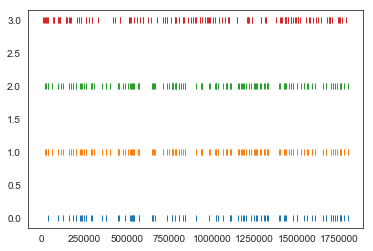

In [21]:
plt.figure()
plt.plot(sorting_KL.get_unit_spike_train(5), 
         0*np.ones(len(sorting_KL.get_unit_spike_train(5))), '|')
plt.plot(sorting_MS4.get_unit_spike_train(4), 
         1*np.ones(len(sorting_MS4.get_unit_spike_train(4))), '|')
plt.plot(sorting_TDC.get_unit_spike_train(0), 
         2*np.ones(len(sorting_TDC.get_unit_spike_train(0))), '|')
plt.plot(agr_3.get_unit_spike_train(4), 
         3*np.ones(len(agr_3.get_unit_spike_train(4))), '|')

print('Klusta spike train length', len(sorting_KL.get_unit_spike_train(5)))
print('Mountainsort spike train length', len(sorting_MS4.get_unit_spike_train(4)))
print('Tridesclous spike train length', len(sorting_TDC.get_unit_spike_train(0)))
print('Agreement spike train length', len(agr_3.get_unit_spike_train(4)))

As we can see, the best match is between Mountainsort and Tridesclous, but only the true positive spikes make up the agreement spike train

## 4) Run systematic performance comparison

This part of the notebook illustrates how to run systematic performance comparisons on ground truth recordings

This will be done with mainly with 2 functions:
  * **spiketoolkit.sorters.run_sorters** : this run several sorters on serevals dataset
  * **spiketoolkit.comparison.gather_sorting_comparison** : this run several all possible comparison
    with ground truth and results some metrics (accuracy, true positive rate, ..)



### 4.1 Generate several dataset with "toy_example"

We first generate two recordings to be compared.

In [22]:
rec0, gt_sorting0 = se.example_datasets.toy_example(num_channels=4, duration=30, seed=10)
rec1, gt_sorting1 = se.example_datasets.toy_example(num_channels=32, duration=30, seed=20)

To check which spike sorters are available, we can run:

In [23]:
st.sorters.available_sorters()

['herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'klusta',
 'mountainsort4',
 'spykingcircus',
 'tridesclous']

### 4.2 Run several sorters on all datasets

In [24]:
# this cell is really verbose due to some sorter so switch off output console

recording_dict = {'toy_tetrode' : rec0, 'toy_probe32': rec1}
sorter_list = ['klusta', 'spykingcircus', 'tridesclous', 'herdingspikes']
path = Path('comparison_example')
working_folder = path / 'working_folder'
if working_folder.is_dir():
    shutil.rmtree(str(working_folder))

t0 = time.perf_counter()
st.sorters.run_sorters(sorter_list, recording_dict, working_folder, engine=None)
t1 = time.perf_counter()
print('total run time', t1-t0)

'group' property is not available and it will not be saved.


AssertionError: This sorter spykingcircus is not installed.
        Please install it with:  

        >>> pip install spyking-circus
        
        Need OpenMPI working, for ubuntu do: 
            sudo apt install libopenmpi-dev"
        
        More information on Spyking-Circus at: "
            https://spyking-circus.readthedocs.io/en/latest/
     

### 4.3 Collect dataframes for comparison

As shown previously, the performance is returned as a pandas dataframe. The `gather_sorting_comparison` function, gathers all the outputs in the working folder and merges them in a single dataframe.

In [ ]:
ground_truths = {'toy_tetrode': gt_sorting0, 'toy_probe32': gt_sorting1}

comp, dataframes = st.comparison.gather_sorting_comparison(working_folder, ground_truths, use_multi_index=True)

### 4.4 Display comparison tables

Pandas dataframes can be nicely displayed as tables in the notebook.

In [ ]:
dataframes.keys()

In [ ]:
dataframes['perf_pooled_with_sum']

In [ ]:
dataframes['perf_pooled_with_average']

In [ ]:
dataframes['run_times']

### 4.5 Easy plot with seaborn

Seaborn allows to easily plot pandas dataframes. Let's see some examples.

In [ ]:
run_times = dataframes['run_times'].reset_index()
fig, ax = plt.subplots()
sn.barplot(data=run_times, x='rec_name', y='run_time', hue='sorter_name', ax=ax)
ax.set_title('Run times')

In [ ]:
perfs = dataframes['perf_pooled_with_average'].reset_index()
fig, ax = plt.subplots()
sn.barplot(data=perfs, x='rec_name', y='tp_rate', hue='sorter_name', ax=ax)
ax.set_title('True positive rate')
ax.set_ylim(0, 100)

In [ ]:
perfs = dataframes['perf_pooled_with_sum'].reset_index()
fig, ax = plt.subplots()
ax = sn.barplot(data=perfs, x='rec_name', y='accuracy', hue='sorter_name', ax=ax)
ax.set_title('accuracy')
ax.set_ylim(0, 100)

This notebook showed the capabilities of `spiketoolkit` to perform pair-wise comparisons between spike sorting outputs, comparisons among multiple sorters and consensus-based spike sorting, and systematic comparisons for grount-truth data.